In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
words = open('names.txt', 'r').read().splitlines()


In [37]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [38]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [39]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [40]:
# Summary ------

In [41]:
# Let's train a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # with the kaiming initialization so we divide by sqrt(fan_in)
        # to keep the variance of activations roughly constant across layers
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters trained with backprop
        self.gamma = torch.ones((1, dim))
        self.beta = torch.zeros((1, dim))
        # buffers (trained with a running `momentum update')
        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                # Update running stats
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)
vocab_size = len(stoi)
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True


46497


In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X and Y

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # (batch_size, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # cross-entropy loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2962
  10000/ 200000: 2.3341
  20000/ 200000: 2.0329
  30000/ 200000: 1.7318
  40000/ 200000: 2.1076
  50000/ 200000: 2.2373
  60000/ 200000: 1.8676
  70000/ 200000: 2.1042
  80000/ 200000: 2.4258
  90000/ 200000: 1.7917
 100000/ 200000: 2.3039
 110000/ 200000: 2.2994
 120000/ 200000: 2.1732
 130000/ 200000: 2.1315
 140000/ 200000: 1.6905
 150000/ 200000: 1.6595
 160000/ 200000: 1.9609
 170000/ 200000: 1.6900
 180000/ 200000: 2.1835
 190000/ 200000: 1.9373


layer 1 (      Tanh): mean -0.06, std 0.88 saturated: 53.94%
layer 3 (      Tanh): mean -0.02, std 0.91 saturated: 58.97%
layer 5 (      Tanh): mean -0.01, std 0.92 saturated: 62.09%
layer 7 (      Tanh): mean -0.06, std 0.93 saturated: 63.69%
layer 9 (      Tanh): mean 0.03, std 0.84 saturated: 37.81%


Text(0.5, 1.0, 'Activation distribution')

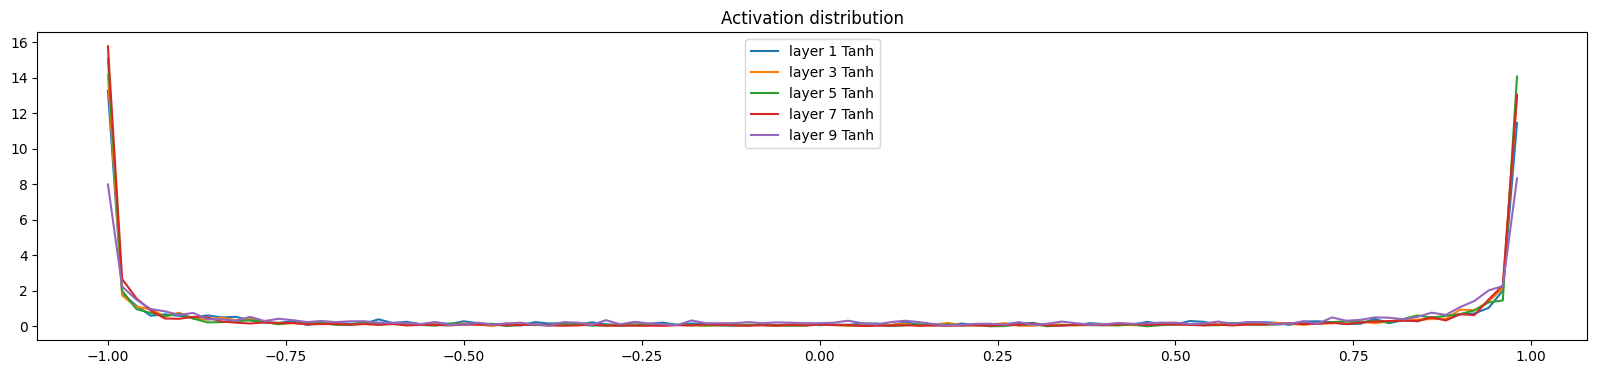

In [43]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %.2f, std %.2f saturated: %0.2f%%' \
              % (i, 'Tanh', t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean().item() * 100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} Tanh')
plt.legend(legends)
plt.title("Activation distribution")

layer 1 ( Tanh grad): mean 0.000039, std 0.002822
layer 3 ( Tanh grad): mean 0.000017, std 0.002665
layer 5 ( Tanh grad): mean -0.000018, std 0.003081
layer 7 ( Tanh grad): mean -0.000035, std 0.003820
layer 9 ( Tanh grad): mean -0.000069, std 0.004615


Text(0.5, 1.0, 'Gradient distribution')

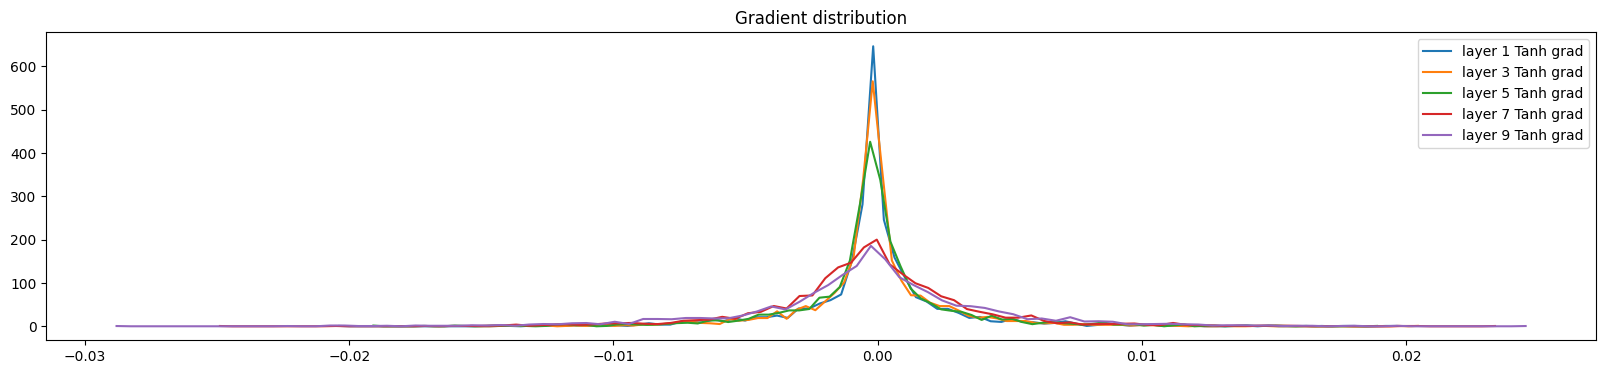

In [45]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %f, std %f' \
              % (i, 'Tanh grad', t.mean().item(), t.std().item()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} Tanh grad')
plt.legend(legends)
plt.title("Gradient distribution")